In [ ]:
!pip install pandas
!pip install numpy==1.23

In [ ]:
!pip install tensorflow==2.12
!pip install pyarabic

In [ ]:
!pip install transformers

In [ ]:
!pip install ipywidgets
!pip install datasets
!pip install transformers[torch]
!pip install nvidia-ml-py3

2023-07-24 19:41:03.817360: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-24 19:41:03.839013: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 19:41:04.363913: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [1]:
# cell-1  
#load and clean the data (removing diacritics and unwanted text)

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

import numpy as np
import pandas as pd
import pyarabic.araby as araby
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report



pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 1000)


df = pd.read_csv('poemsDataset.csv')
df.fillna('', inplace=True)
display(len(df))


def remove_diacritics(a):    
    return araby.strip_diacritics(a)

df['first_hemistich'] = df['first_hemistich'].apply(remove_diacritics)
df['second_hemistich'] = df['second_hemistich'].apply(remove_diacritics)

def normalizeBeforeTraining(df):
    df['first_hemistich'] = df['first_hemistich'].str.replace('النابغـة: ', '')
    df['second_hemistich'] = df['second_hemistich'].str.replace('الـربيع: ', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('عبيــد: ', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('امـرؤ القيسـ: ', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('امرؤ القيس: ', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('(جلال الــــدين الــــرومي):', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('(لـوك الفيلسـوف الإنكليزي):', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('(كانت الفيلسوف الألماني ):', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('(بركســــــــــــــــون):', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('(الحـــــــــــــــور):', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('(الشــــــــــــــاعر):', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('(الإنســـــــــــــــان):', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('العلم):', '', regex=False)
    df['first_hemistich'] = df['first_hemistich'].str.replace('(العشــــــــــــــــق):', '', regex=False)
    df['first_hemistich'] = df['first_hemistich'].str.replace('(الزهــــــــــــــــــرة):', '', regex=False)
    df['second_hemistich'] = df['second_hemistich'].str.replace('التوأم اليشكري: ', '', regex=False)  
    df['first_hemistich'] = df['first_hemistich'].str.replace('آ', 'أ')
    df['second_hemistich'] = df['second_hemistich'].str.replace('آ', 'أ')
    df['first_hemistich'] = df['first_hemistich'].str.replace('[/":?،؟]', '')
    df['second_hemistich'] = df['second_hemistich'].str.replace('[/":?،؟]', '')
    df['first_hemistich'] = df['first_hemistich'].str.replace('  ', ' ')
    df['second_hemistich'] = df['second_hemistich'].str.replace('  ', ' ')
    df['first_hemistich'] = df['first_hemistich'].str.replace('  ', ' ')
    df['second_hemistich'] = df['second_hemistich'].str.replace('  ', ' ')


normalizeBeforeTraining(df)
df.drop(df[(df['first_hemistich'] == '') & (df['second_hemistich'] == '')].index, inplace=True)

#if first_hemistich == '', then copy the text from second_hemistich. then delete the text in the second_hemistich
df['first_hemistich'] = df.apply(lambda x: x['second_hemistich'] if x['first_hemistich'] == '' else x['first_hemistich'], axis=1)
df['second_hemistich'] = df.apply(lambda x: '' if x['first_hemistich'] == x['second_hemistich'] else x['second_hemistich'], axis=1)

df.reset_index(drop=True, inplace=True)

display(len(df))
# display(df[:10])
print('done')

2090907

2090907

done


In [2]:
# cell-2 
# preparing data for finetuning


df['second_hemistich'].replace('', 'E', inplace=True)
dfc = df[['first_hemistich', 'second_hemistich', 'rhyme', 'link']].copy()
dfc['text'] = dfc['first_hemistich'] + ' S ' + dfc['second_hemistich']

#removing verses without a rhyme
dfc = dfc[dfc['rhyme'] != ''] 

dfc.reset_index(drop=True, inplace=True)


dfc['rhyme'] = dfc['rhyme'].astype('category')

dfc['label'] = dfc['rhyme'].cat.codes #assign cat_value for each rhyme
dftrain, dftest = train_test_split(dfc, test_size=0.20, random_state=42, stratify=dfc['label'])
ytrain = dftrain['label'].values.tolist()
ytest = dftest['label'].values.tolist()



max_sequence_length = 32
train_batch_size = 256
classes_num = len(dfc['rhyme'].unique())

display(classes_num)
display(len(dfc))
display(len(dftrain))
display(len(dftest))

31

1768284

1414627

353657

In [3]:
#cell-3
#loading the tokenizer and the model

from transformers import AutoTokenizer, BertForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained('faisalq/bert-base-arapoembert')

model = BertForSequenceClassification.from_pretrained('faisalq/bert-base-arapoembert',
                                                      num_labels=classes_num).to('cuda')                                        


2023-07-29 11:04:11.417873: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-29 11:04:11.442057: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-29 11:04:12.197252: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Some weights of the model checkpoint at faisalq/bert-base-arapoembert were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls

In [4]:
#cell-4
#tokenizing the data

xtrain = tokenizer(
    text=dftrain['text'].tolist(),
    add_special_tokens=True,
    max_length = max_sequence_length,
    truncation=True,
    padding='max_length', 
    return_tensors='pt',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


xtest = tokenizer(
    text=dftest['text'].tolist(),
    add_special_tokens=True,
    max_length = max_sequence_length,
    truncation=True,
    padding='max_length', 
    return_tensors='pt',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [7]:
# display(xtest)
display(xtest['input_ids'][0])

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([    2,  2914,   277,   151,  2890,  1110,    83, 31553,  8365,
           9, 25033,   122,    85,  4147,  5444,   678,   321, 40125,
           3,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0], dtype=int32)>

In [5]:
#group text and labels and create train_ds and test_ds

import torch

class NewGroupDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['label'] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

train_ds = NewGroupDataset(xtrain, ytrain)
test_ds = NewGroupDataset(xtest, ytest)

from sklearn.metrics import accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return { 'accuracy': acc }

In [6]:
from transformers import Trainer, TrainingArguments


epochs = 2
save_steps = 10000 #save checkpoint every 10000 steps
batch_size = 256

training_args = TrainingArguments(
    output_dir = 'araPoemBERT_base_rhyme/',
    overwrite_output_dir=True,
    num_train_epochs = epochs,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    save_steps = save_steps,
    save_total_limit = 5, #only save the last 5 checkpoints
    fp16=True,
    learning_rate = 5e-5,  # 5e-5 is the default
    logging_steps = 1000, #50_000
    evaluation_strategy = 'steps',
    # evaluate_during_training = True,
    eval_steps = 1000
    
)

trainer = Trainer(
    model = model,
    args = training_args,
    # data_collator=data_collator,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics = compute_metrics
)


# trainer.train(resume_from_checkpoint=True)
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
1000,0.526700,0.214580,0.956169
2000,0.203800,0.165608,0.967938
3000,0.166800,0.143311,0.972372
4000,0.147900,0.134155,0.973845
5000,0.141900,0.127637,0.975423
6000,0.123200,0.123761,0.976056
7000,0.109200,0.122575,0.976398
8000,0.107400,0.120279,0.976556
9000,0.104600,0.117288,0.977029
10000,0.103100,0.116754,0.977173


TrainOutput(global_step=11052, training_loss=0.16673779245998563, metrics={'train_runtime': 842.493, 'train_samples_per_second': 3358.193, 'train_steps_per_second': 13.118, 'total_flos': 3.883711280131162e+16, 'train_loss': 0.16673779245998563, 'epoch': 2.0})

In [7]:
trainer.save_model('araPoemBERT_base_rhyme/')

In [8]:
p = trainer.predict(test_ds)
y_pred = np.argmax(p[0], axis = 1)

print(classification_report(ytest, y_pred, digits=4))


              precision    recall  f1-score   support

           0     0.9816    0.9482    0.9646     11447
           1     0.9859    0.9848    0.9853     35819
           2     0.9857    0.9884    0.9870     39850
           3     0.9715    0.9811    0.9763      2536
           4     0.9844    0.9850    0.9847     14524
           5     0.9770    0.9821    0.9796      9014
           6     0.9383    0.9638    0.9509       442
           7     0.8965    0.9017    0.8991      6266
           8     0.9464    0.9825    0.9641      5029
           9     0.9785    0.9788    0.9787      3257
          10     0.9408    0.9457    0.9433      5195
          11     0.9610    0.9571    0.9590       489
          12     0.9828    0.9855    0.9842     13517
          13     0.9015    0.6954    0.7851      1382
          14     0.9756    0.9867    0.9811     42434
          15     0.9845    0.9873    0.9859     40603
          16     0.9794    0.9775    0.9784     35087
          17     0.9861    

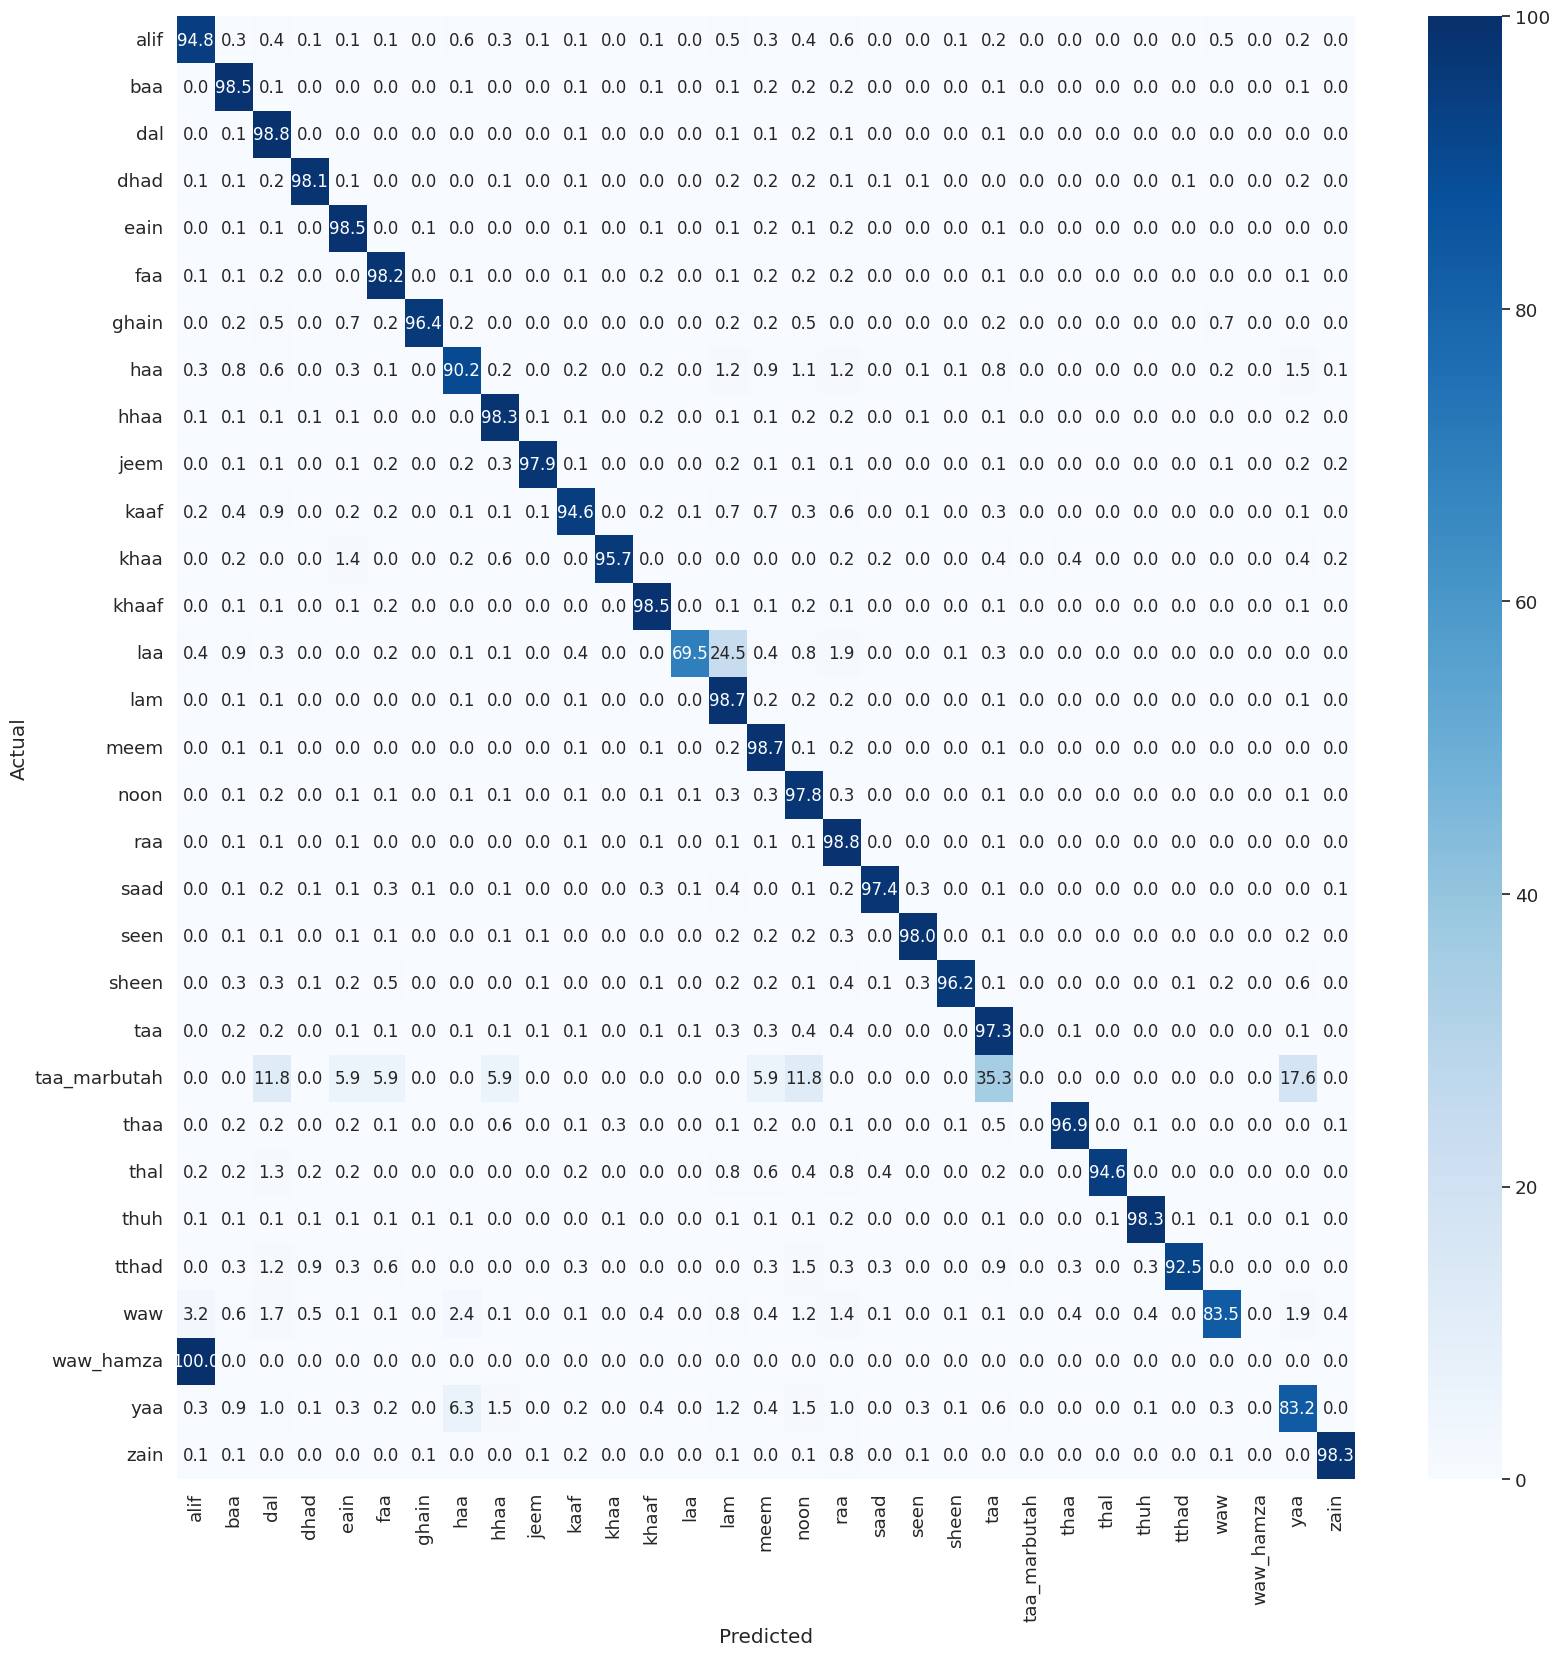

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sn, numpy as np
import matplotlib.pyplot as plt



classes = dfc['rhyme'].cat.categories

matrix = confusion_matrix(ytest, y_pred)
cmn = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
cmn = cmn*100
fig, ax = plt.subplots(figsize=(19,19))
sn.set(font_scale=1.2)
sn.heatmap(cmn, annot=True, fmt='.1f', xticklabels=classes, 
           yticklabels=classes, cmap="Blues",
          annot_kws={"size": 12})
plt.yticks(rotation=0)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('rhyme_cm.png')
plt.show(block=False)


In [14]:
dfc['m'] = dfc['rhyme'].astype(str) + ' ' + dfc['label'].astype(str)
df2 = dfc.groupby(['m'])['text'].count().sort_values()
display(df2)

m
waw_hamza 28            9
taa_marbutah 22        84
tthad 26             1677
ghain 6              2208
khaa 11              2446
thal 24              2605
waw 27               3907
thaa 23              4344
saad 18              5048
sheen 20             5102
zain 30              5252
laa 13               6910
thuh 25              8092
dhad 3              12678
jeem 9              16286
hhaa 8              25146
kaaf 10             25974
yaa 29              29037
haa 7               31330
seen 19             34605
faa 5               45069
taa 21              48032
alif 0              57236
khaaf 12            67584
eain 4              72620
noon 16            175434
baa 1              179095
dal 2              199249
meem 15            203015
lam 14             212168
raa 17             286042
Name: text, dtype: int64

In [15]:
dfc['rhyme'].cat.categories

Index(['alif', 'baa', 'dal', 'dhad', 'eain', 'faa', 'ghain', 'haa', 'hhaa',
       'jeem', 'kaaf', 'khaa', 'khaaf', 'laa', 'lam', 'meem', 'noon', 'raa',
       'saad', 'seen', 'sheen', 'taa', 'taa_marbutah', 'thaa', 'thal', 'thuh',
       'tthad', 'waw', 'waw_hamza', 'yaa', 'zain'],
      dtype='object')

In [30]:
dd = pd.read_csv('rhyme_cls_report.txt', sep="\s+")
dd['class'] = dfc['rhyme'].cat.categories
dd.to_csv('rhyme_cls_report.csv', encoding='utf-8', index=False)

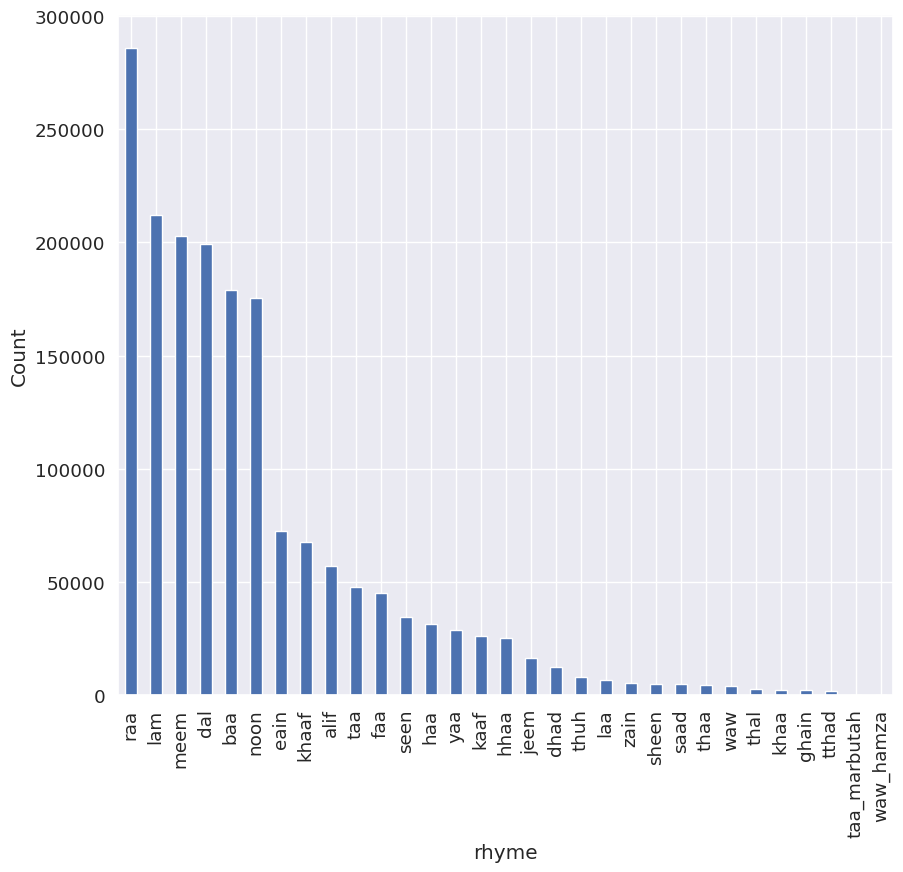

In [51]:
plt.subplots(figsize=(10,10))
plt.subplots_adjust(bottom=0.20)
plt.rcParams.update({'font.size': 24})
dfc['rhyme'].value_counts().plot(kind='bar')
plt.ylabel('Count')
# plt.xlabel('Predicted')
plt.savefig('rhyme_distribution.png')
plt.ylabel('Count')
plt.show()